In [312]:
# import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

In [313]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [314]:
full_data = [train, test]

In [315]:
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [316]:
train.shape, test.shape

((891, 12), (418, 11))

In [317]:
print('Percentage of class Survived: ', round(len(train.loc[train['Survived']==1,:])/len(train),3))
print('Percentage of class not Survived: ', round(len(train.loc[train['Survived']==0,:])/len(train),3))

Percentage of class Survived:  0.384
Percentage of class not Survived:  0.616


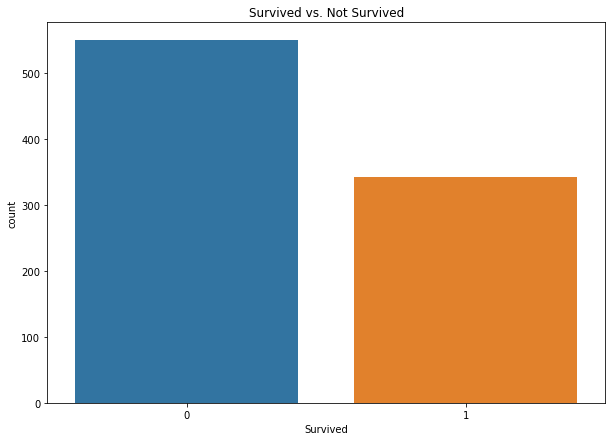

In [318]:
# Above percentages clearly show that data is imbalanced, we will be handling this later
# let's plot them
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.countplot(train['Survived'])
ax.set_title('Survived vs. Not Survived')
plt.show()

### 1. Analysis of Categorical Variables

#### 1.1 Pclass vs Survived

In [319]:
train.loc[:,['Pclass', 'Survived']].groupby('Pclass').mean()

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

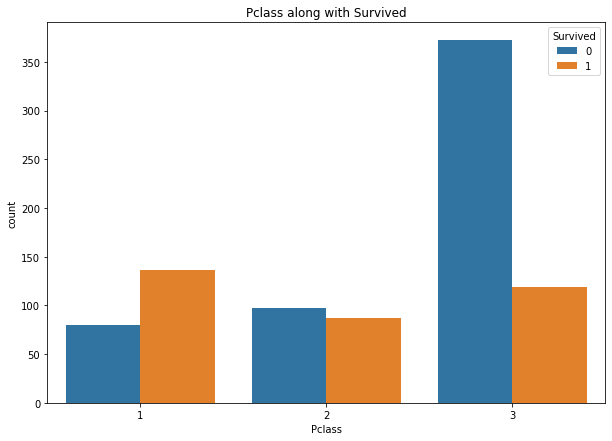

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.countplot('Pclass', hue='Survived', data=train)
ax.set_title('Pclass along with Survived')
plt.show()

<p>Highest survival rate for those belong to Pclass of 1</p>

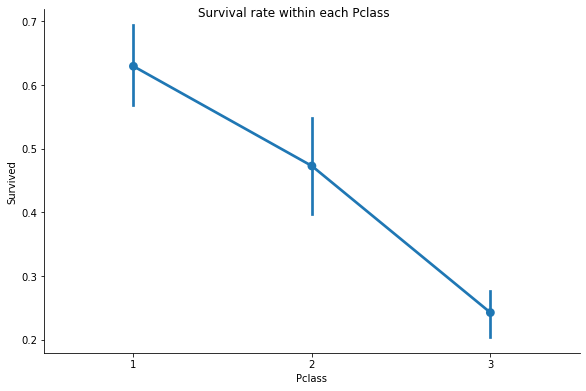

In [321]:
# let's visualize how survival rate varies as per the Pclass
fig = sns.factorplot('Pclass', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Survival rate within each Pclass')
plt.show()

#### 1.2 Sex vs Survived

In [322]:
train['Sex'].isnull().sum()

0

In [323]:
train.loc[:,['Sex', 'Survived']].groupby('Sex').sum()

Survived
Sex             
female       233
male         109

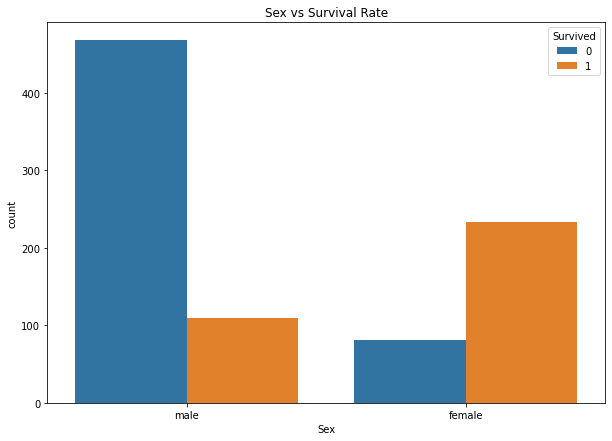

In [324]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('Sex', hue='Survived', data=train)
ax.set_title('Sex vs Survival Rate')
plt.show()

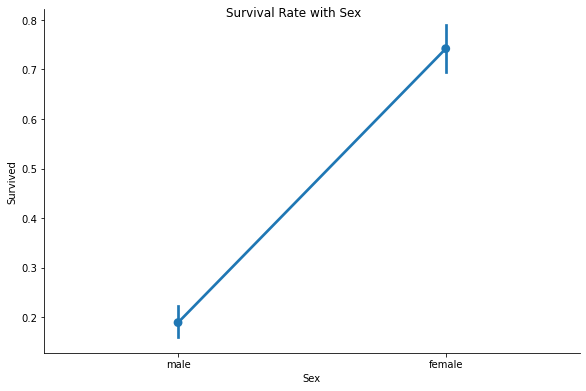

In [325]:
# It's clearly seen that females were given priority during rescue. Let's plot factorplot
fig = sns.factorplot('Sex', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Survival Rate with Sex')
plt.show()

#### 1.3 Embarked vs Survived

In [326]:
train['Embarked'].isnull().sum()

2

In [327]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [328]:
train.loc[train['Embarked'].isnull(),['Embarked']] = 'S'

In [329]:
train['Embarked'].isnull().sum()

0

In [330]:
train.loc[:,['Embarked', 'Survived']].groupby('Embarked').mean()

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009

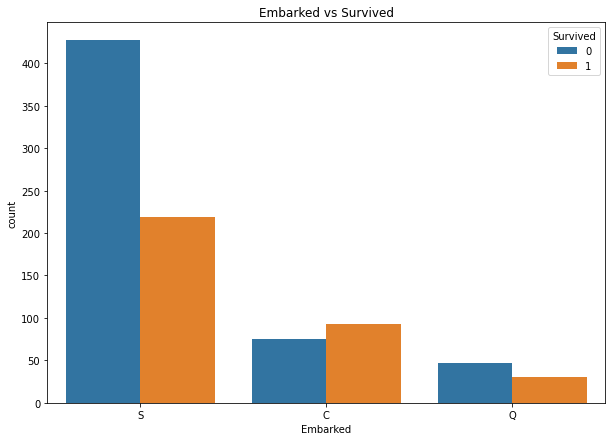

In [331]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('Embarked', hue='Survived', data=train)
ax.set_title('Embarked vs Survived')
plt.show()

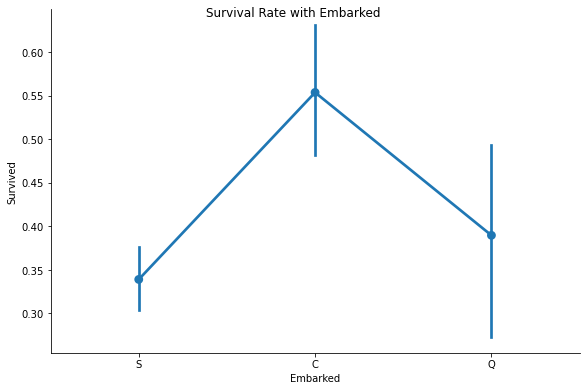

In [332]:
fig = sns.factorplot('Embarked', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Survival Rate with Embarked')
plt.show()

<p>Highest survival rate for those with Embarked=C while least for Embarked=S</p>

#### 1.4 Cabin vs Survived

In [333]:
train['Cabin'].isnull().sum()

687

In [334]:
print('Percentage of Null values in Cabin: {}. That;s why Cabin will not be considered for further analysis and modeling.'.format(round(train['Cabin'].isnull().sum()/len(train), 3)*100))

Percentage of Null values in Cabin: 77.10000000000001. That;s why Cabin will not be considered for further analysis and modeling.


In [335]:
for dataset in full_data:
    dataset.drop('Cabin', axis=1, inplace=True)

#### 1.5 Ticket vs Survived

In [336]:
train['Ticket'].isnull().sum()

0

In [337]:
train['Ticket'].value_counts()

CA. 2343    7
1601        7
347082      7
CA 2144     6
3101295     6
           ..
7598        1
240929      1
33638       1
349216      1
347064      1
Name: Ticket, Length: 681, dtype: int64

<p>No null values in Ticket but ambigious values. That's why it will not be part of further analysis.</p>

In [338]:
for dataset in full_data:
    dataset.drop('Ticket', axis=1, inplace=True)

#### 1.6 Name vs Survived

In [339]:
train['Name'].isnull().sum()

0

In [340]:
train['Name'].value_counts()

Wiseman, Mr. Phillippe                                                 1
Aks, Mrs. Sam (Leah Rosen)                                             1
Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")    1
Danbom, Mr. Ernst Gilbert                                              1
Bourke, Miss. Mary                                                     1
                                                                      ..
Kink-Heilmann, Miss. Luise Gretchen                                    1
Roebling, Mr. Washington Augustus II                                   1
Holverson, Mr. Alexander Oskar                                         1
Silven, Miss. Lyyli Karoliina                                          1
Dorking, Mr. Edward Arthur                                             1
Name: Name, Length: 891, dtype: int64

<p>Observed the same as in case of Ticket. Too much ambiguity. But let's try to find out title from name and analyze with survival</p>

In [341]:
def get_title(name):
    title = re.search(" ([A-Za-z]+)\.", name)
    if title:
        return title.group(1)
    else:
        return ""

In [342]:
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [343]:
train[['Title', 'Name']]

Title                                               Name
0      Mr                            Braund, Mr. Owen Harris
1     Mrs  Cumings, Mrs. John Bradley (Florence Briggs Th...
2    Miss                             Heikkinen, Miss. Laina
3     Mrs       Futrelle, Mrs. Jacques Heath (Lily May Peel)
4      Mr                           Allen, Mr. William Henry
..    ...                                                ...
886   Rev                              Montvila, Rev. Juozas
887  Miss                       Graham, Miss. Margaret Edith
888  Miss           Johnston, Miss. Catherine Helen "Carrie"
889    Mr                              Behr, Mr. Karl Howell
890    Mr                                Dooley, Mr. Patrick

[891 rows x 2 columns]

In [344]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Ms            1
Sir           1
Lady          1
Don           1
Capt          1
Jonkheer      1
Mme           1
Countess      1
Name: Title, dtype: int64

In [345]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [346]:
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Rev', 'Dr', 'Col', 'Major', 'Jonkheer', 'Don', 'Sir', 'Dona', 'Countess', 'Capt'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms', 'Lady', 'Mme'], 'Miss')

In [347]:
train['Title'].value_counts()

Mr        517
Miss      187
Mrs       125
Master     40
Rare       22
Name: Title, dtype: int64

In [348]:
test['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: Title, dtype: int64

In [349]:
for dataset in full_data:
    dataset.drop('Name', axis=1, inplace=True)

In [350]:
train.loc[:,["Title", "Survived"]].groupby("Title").mean()

Survived
Title           
Master  0.575000
Miss    0.705882
Mr      0.156673
Mrs     0.792000
Rare    0.318182

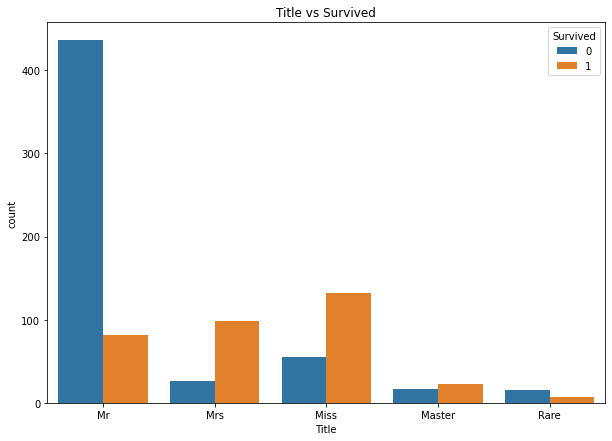

In [351]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('Title', hue='Survived', data=train)
ax.set_title('Title vs Survived')
plt.show()

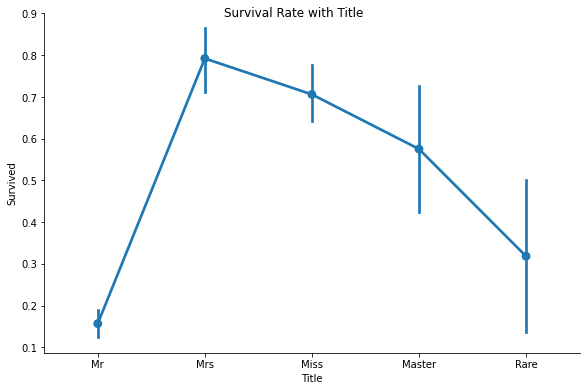

In [352]:
fig = sns.factorplot('Title', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Survival Rate with Title')
plt.show()

<p>Highest survival rate is observed with title <b>Miss</b> and <b>Mrs</b> which points towards the gender <b>Female</b>.</p>

<p>Trends observed till now is that highest survival rate for pclass of 1 & 2, fares category with high values and gender with value female. Let's analyze them together to get better assence.</p>

### 2. Analysis of Continous Variables

#### 2.1 Age vs Survived

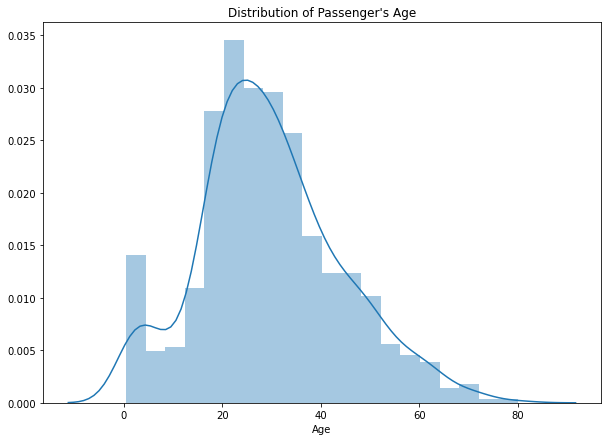

In [353]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.distplot(train['Age'])
ax.set_title("Distribution of Passenger's Age")
plt.show()

In [354]:
# null values of age in training set
train['Age'].isnull().sum()

177

In [355]:
mean_age = train['Age'].mean()
mean_age

29.69911764705882

In [356]:
median_age = train['Age'].median()
median_age

28.0

In [357]:
# mean is little greater than median, that's why we will be using median to fill null values
train.loc[train['Age'].isnull(),'Age'] = median_age
train['Age'].isnull().sum()

0

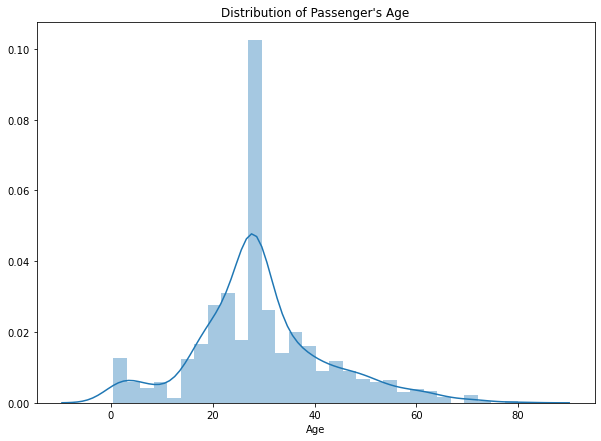

In [358]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
sns.distplot(train['Age'])
ax.set_title("Distribution of Passenger's Age")
plt.show()

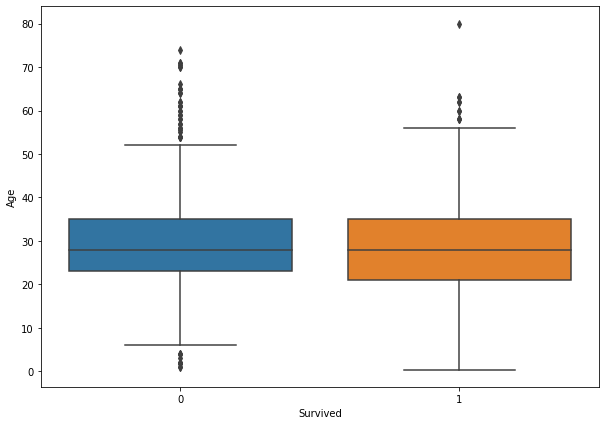

In [359]:
# Now, Age does not have null values & got more normalize than before
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot('Survived', 'Age', data=train)
plt.show()

In [360]:
# It seems that Age is not significant to detect survival of passenger. Let's catgorize them
for dataset in full_data:
    dataset['Age_Cat'] = pd.qcut(dataset['Age'], 5, duplicates='drop')

In [361]:
train.loc[:,['Age_Cat', 'Survived']].groupby('Age_Cat').mean()

Survived
Age_Cat                
(0.419, 20.0]  0.458101
(20.0, 28.0]   0.327778
(28.0, 38.0]   0.434286
(38.0, 80.0]   0.372881

In [362]:
for dataset in full_data:
    dataset.loc[dataset['Age']<=20, 'Age_Category'] = 0
    dataset.loc[(dataset['Age']>20) & (dataset['Age']<=28), 'Age_Category'] = 1
    dataset.loc[(dataset['Age']>28) & (dataset['Age']<=38), 'Age_Category'] = 2
    dataset.loc[dataset['Age']>38, 'Age_Category'] = 3

In [363]:
train.loc[:,['Age_Category', 'Survived']].groupby('Age_Category').mean()

Survived
Age_Category          
0.0           0.458101
1.0           0.327778
2.0           0.434286
3.0           0.372881

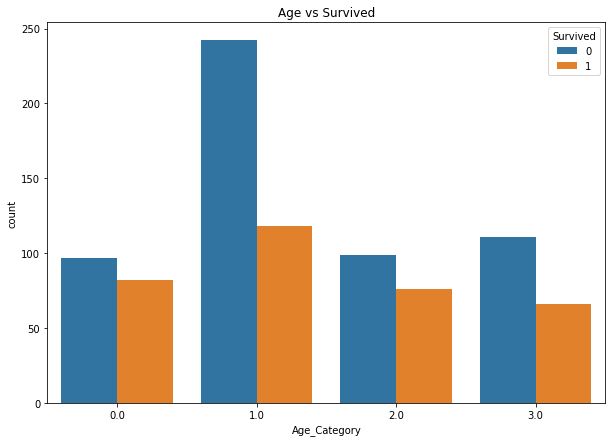

In [364]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('Age_Category', hue='Survived', data=train)
ax.set_title('Age vs Survived')
plt.show()

Text(0.5, 0.98, 'Age vs Survived')

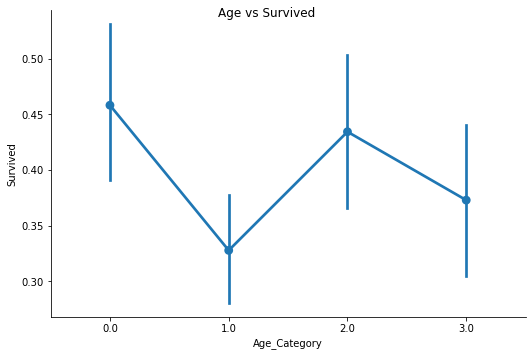

In [365]:
fig = sns.factorplot('Age_Category', 'Survived', data=train, size=5, aspect=1.5)
fig.fig.suptitle('Age vs Survived')

<p>Highest survival rate for age category of 0 while least for 1.</p>

#### 2.2 Fare vs Survived

In [366]:
train['Fare'].isnull().sum()

0

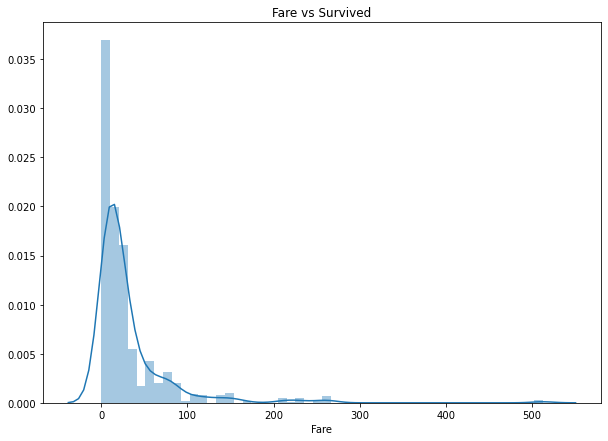

In [367]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.distplot(train['Fare'])
ax.set_title('Fare vs Survived')
plt.show()

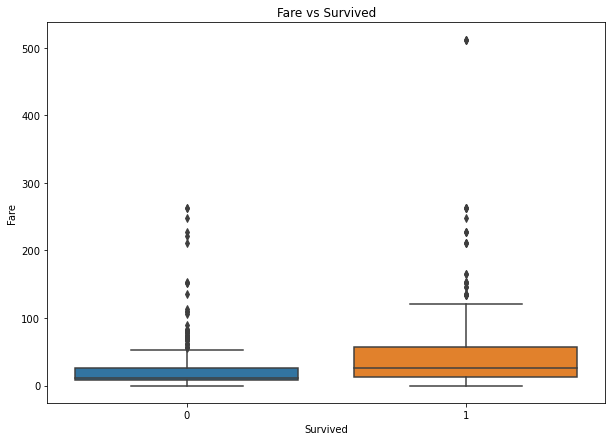

In [368]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot('Survived', 'Fare', data=train)
ax.set_title('Fare vs Survived')
plt.show()

In [369]:
# As boxplot shows above, there are some outliers exist in Fare. Firstly, remove them before further processing
fare_25 = np.percentile(train['Fare'], 25)
fare_75 = np.percentile(train['Fare'], 75)
fare_iqr = fare_75 - fare_25

In [370]:
fare_25, fare_75, fare_iqr

(7.9104, 31.0, 23.0896)

In [371]:
lower_bound = fare_25 - (1.5 * fare_iqr)
upper_bound = fare_75 + (1.5 * fare_iqr)

In [372]:
lower_bound, upper_bound

(-26.724, 65.6344)

In [373]:
full_data[0].shape

(891, 12)

In [378]:
train = train.loc[(train['Fare']>=lower_bound) & (train['Fare']<=upper_bound),:].reset_index(drop=True)
full_data[0] = train

In [380]:
test = test.loc[(test['Fare']>=lower_bound) & (test['Fare']<=upper_bound),:].reset_index(drop=True)
full_data[1] = test

In [381]:
train['Fare'].min(), train['Fare'].max()

(0.0, 65.0)

In [382]:
test['Fare'].min(), test['Fare'].max()

(0.0, 65.0)

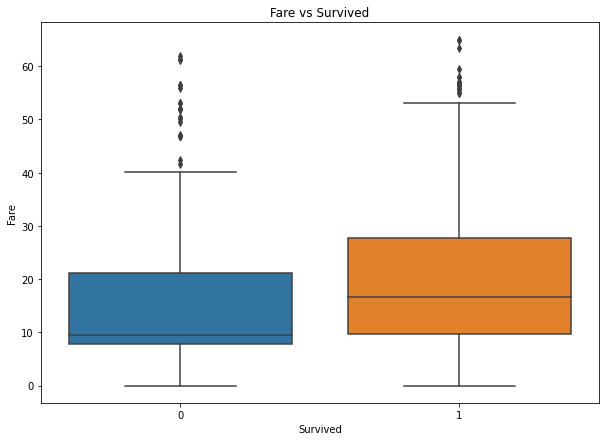

In [383]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot('Survived', 'Fare', data=train)
ax.set_title('Fare vs Survived')
plt.show()

In [384]:
for dataset in full_data:
    dataset['Fare_Category'] = pd.qcut(dataset['Fare'], 5)

In [385]:
train['Fare_Category'].value_counts()

(15.246, 26.55]    156
(8.795, 15.246]    156
(-0.001, 7.775]    156
(7.775, 8.795]     154
(26.55, 65.0]      153
Name: Fare_Category, dtype: int64

In [386]:
train.loc[:,['Fare_Category', 'Survived']].groupby('Fare_Category').mean()

Survived
Fare_Category            
(-0.001, 7.775]  0.205128
(7.775, 8.795]   0.194805
(8.795, 15.246]  0.352564
(15.246, 26.55]  0.493590
(26.55, 65.0]    0.450980

In [387]:
for dataset in full_data:
    dataset['Fare_Category'] = 0
    dataset.loc[dataset['Fare']<=7.775, 'Fare_Category'] = 0
    dataset.loc[(dataset['Fare']>7.775) & (dataset['Fare']<=8.795), 'Fare_Category'] = 1
    dataset.loc[(dataset['Fare']>8.795) & (dataset['Fare']<=15.246), 'Fare_Category'] = 2
    dataset.loc[(dataset['Fare']>15.246) & (dataset['Fare']<=26.55), 'Fare_Category'] = 3
    dataset.loc[dataset['Fare']>26.55, 'Fare_Category'] = 4

In [388]:
train.loc[:,['Fare_Category', 'Survived']].groupby('Fare_Category').mean()

Survived
Fare_Category          
0              0.205128
1              0.194805
2              0.352564
3              0.493590
4              0.450980

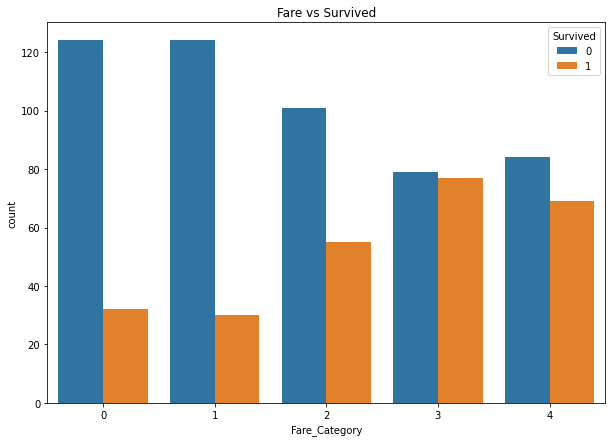

In [389]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('Fare_Category', hue='Survived', data=train)
ax.set_title('Fare vs Survived')
plt.show()

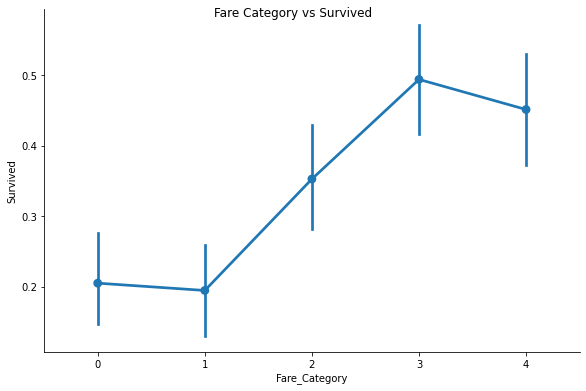

In [390]:
fig = sns.factorplot('Fare_Category', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Fare Category vs Survived')
plt.show()

<p>Increase in survival rate with the increase of Fare. There is slightly drop in survival rate for fare category 4 but overall there is increase.</p>

### 3. Analysis of Discrete Variables

#### 3.1 SibSp , Parch vs Survived

In [391]:
for dataset in full_data:
    dataset['FamilyMembers'] = dataset['SibSp'].astype('int64') + dataset['Parch'].astype('int64') + 1

In [392]:
train['FamilyMembers'].dtype, test['FamilyMembers'].dtype

(dtype('int64'), dtype('int64'))

In [393]:
train.loc[:,['FamilyMembers', 'Survived']].groupby('FamilyMembers').mean()

Survived
FamilyMembers          
1              0.270378
2              0.487603
3              0.575000
4              0.727273
5              0.076923
6              0.055556
7              0.333333
8              0.000000

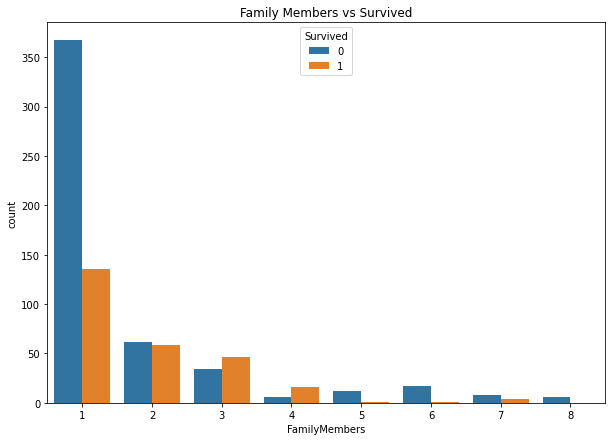

In [394]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.countplot('FamilyMembers', hue='Survived', data=train)
ax.set_title('Family Members vs Survived')
plt.show()

Text(0.5, 0.98, 'Survival Rate a/c to Family Members')

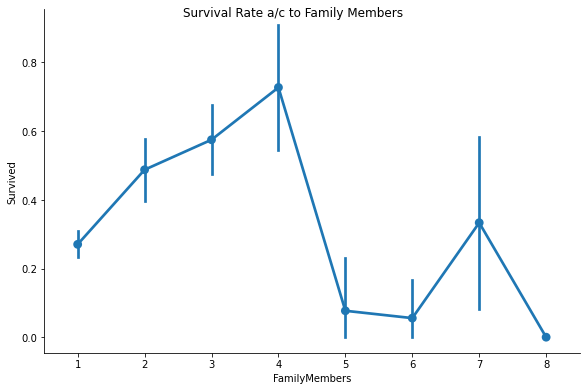

In [395]:
fig = sns.factorplot('FamilyMembers', 'Survived', data=train, size=5.5, aspect=1.5)
fig.fig.suptitle('Survival Rate a/c to Family Members')

<p>Highest survival rate for passengers with 4 family members while least for 8.</p>

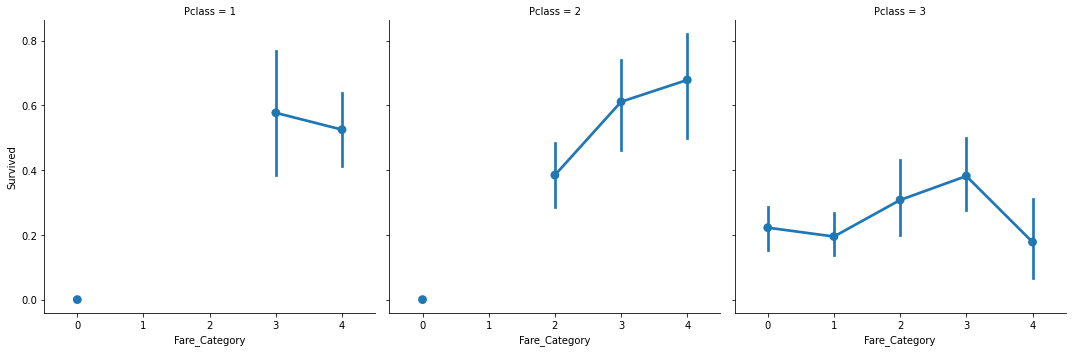

In [396]:
# Since, there is an increase in survival rate with increase in fare as well as moving lower to standard in pclass.
# So, let's analyze of there is co-relation between Fare and Pclass
fig = sns.factorplot('Fare_Category', 'Survived', col='Pclass', data=train)

<p>It shows that high class people were given priority during rescue. High survival rate for high fare and pclass of 1 & 2.</p>

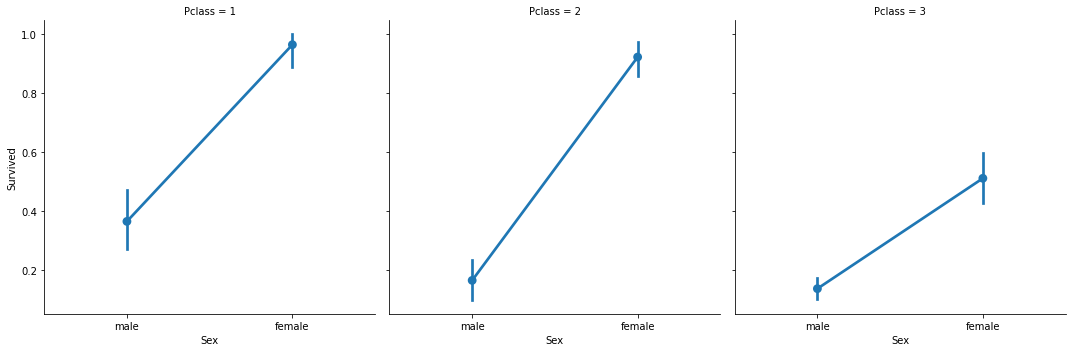

In [397]:
# Survival rate for Sex and Pclass together
sns.factorplot('Sex', 'Survived', col='Pclass', data=train)

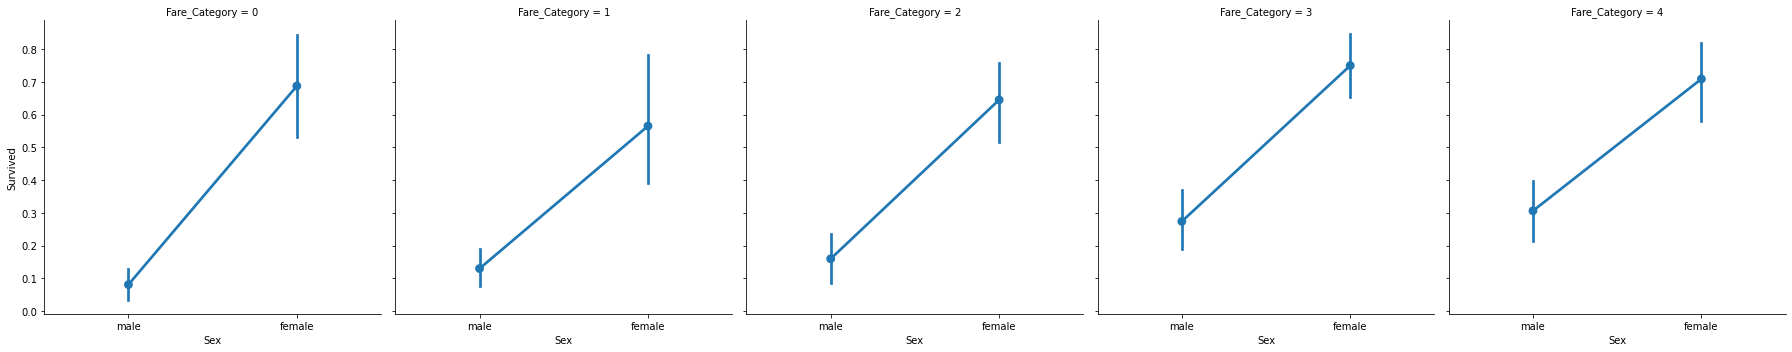

In [398]:
# Survival rate for Sex and Pclass together
sns.factorplot('Sex', 'Survived', col='Fare_Category', data=train)

<p>Highest survival rate for female irrespective of pclass and fare.</p>

### 4. Variable Selection

In [399]:
# remove uneccesary or redundant columns
for dataset in full_data:
    dataset.drop(['PassengerId', 'Age', 'Age_Cat', 'SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

In [400]:
train.head()

Survived  Pclass     Sex Embarked Title  Age_Category  Fare_Category  \
0         0       3    male        S    Mr           1.0              0   
1         1       3  female        S  Miss           1.0              1   
2         1       1  female        S   Mrs           2.0              4   
3         0       3    male        S    Mr           2.0              1   
4         0       3    male        Q    Mr           1.0              1   

   FamilyMembers  
0              2  
1              1  
2              2  
3              1  
4              1

In [401]:
train.shape

(775, 8)

In [402]:
test.shape

(362, 7)

### 5. Encoding Categorical Variable

In [403]:
train.head()

Survived  Pclass     Sex Embarked Title  Age_Category  Fare_Category  \
0         0       3    male        S    Mr           1.0              0   
1         1       3  female        S  Miss           1.0              1   
2         1       1  female        S   Mrs           2.0              4   
3         0       3    male        S    Mr           2.0              1   
4         0       3    male        Q    Mr           1.0              1   

   FamilyMembers  
0              2  
1              1  
2              2  
3              1  
4              1

In [404]:
train.shape, test.shape

((775, 8), (362, 7))

In [411]:
for index, dataset in enumerate(full_data):
    full_data[index] = pd.concat([dataset, pd.get_dummies(dataset['Sex'])], axis=1)
    full_data[index].drop('Sex', axis=1, inplace=True)

In [412]:
full_data[0].shape, full_data[1].shape

((775, 9), (362, 8))

In [423]:
for index, dataset in enumerate(full_data):
    full_data[index] = pd.concat([dataset, pd.get_dummies(dataset['Embarked'], prefix='Embarked')], axis=1)
    full_data[index].drop('Embarked', axis=1, inplace=True)

In [416]:
full_data[0].shape, full_data[1].shape

((775, 11), (362, 10))

In [417]:
for index, dataset in enumerate(full_data):
    full_data[index] = pd.concat([dataset, pd.get_dummies(dataset['Title'])], axis=1)
    full_data[index].drop('Title', axis=1, inplace=True)

In [418]:
full_data[0].shape, full_data[1].shape

((775, 15), (362, 14))

In [419]:
train = full_data[0]
test = full_data[1]

In [420]:
train.shape, test.shape

((775, 15), (362, 14))

In [421]:
train.head()

Survived  Pclass  Age_Category  Fare_Category  FamilyMembers  female  male  \
0         0       3           1.0              0              2       0     1   
1         1       3           1.0              1              1       1     0   
2         1       1           2.0              4              2       1     0   
3         0       3           2.0              1              1       0     1   
4         0       3           1.0              1              1       0     1   

   C  Q  S  Master  Miss  Mr  Mrs  Rare  
0  0  0  1       0     0   1    0     0  
1  0  0  1       0     1   0    0     0  
2  0  0  1       0     0   0    1     0  
3  0  0  1       0     0   1    0     0  
4  0  1  0       0     0   1    0     0

In [424]:
test.head()

Pclass  Age_Category  Fare_Category  FamilyMembers  female  male  C  Q  S  \
0       3           2.0              1              1       0     1  0  1  0   
1       3           3.0              0              2       1     0  0  0  1   
2       2           3.0              2              1       0     1  0  1  0   
3       3           1.0              1              1       0     1  0  0  1   
4       3           1.0              2              3       1     0  0  0  1   

   Master  Miss  Mr  Mrs  Rare  
0       0     0   1    0     0  
1       0     0   0    1     0  
2       0     0   1    0     0  
3       0     0   1    0     0  
4       0     0   0    1     0

In [426]:
train.to_csv(r'./titanic/train_set.csv', index=None)
test.to_csv(r'./titanic/test_set.csv', index=None)